# Reading

In [1]:
import numpy as np
import pickle as pickle
import pandas as pd
import scipy
import sklearn
import gzip
import json
from tqdm import tqdm
import os
from collections import Counter
from datetime import datetime
import math
import torch 
import torch.nn as nn
tqdm.pandas() #for progres_apply etc.

In [2]:
def parse_probe():
    parsed_data = []
    with open(f"netflix/probe.txt") as f:
        movie = None
        for line in tqdm(f):
            if line[-2] == ":":
                movie = int(line[:-2])
            else:
                user = line[:-1]
                parsed_data.append({"movie_user": str(movie) + "_" + user, "movie": movie, "user": int(user)})

    return pd.DataFrame.from_dict(parsed_data)

df_val = parse_probe()

1425333it [00:00, 1628583.24it/s]


In [3]:
def parse_netflix():
    parsed_data = []
    for i in range(1, 2):
        with open(f"netflix/combined_data_{i}.txt") as f:
            movie = None
            for line in tqdm(f):
                if line[-2] == ":":
                    movie = int(line[:-2])
                else:
                    user, rating, rating_time = line[:-1].split(',')
                    movie_user = str(movie) + "_" + user
                    parsed_data.append({"movie": movie, "user": int(user), "rating": int(rating), "time": rating_time, "movie_user": movie_user})

    return pd.DataFrame.from_dict(parsed_data)

df = parse_netflix()
df["validation"] = df.movie_user.isin(df_val.movie_user)
df.head()

24058263it [00:21, 1120694.96it/s]


,movie,user,rating,time,movie_user,validation
0,1,1488844,3,2005-09-06,1_1488844,False
1,1,822109,5,2005-05-13,1_822109,False
2,1,885013,4,2005-10-19,1_885013,False
3,1,30878,4,2005-12-26,1_30878,True
4,1,823519,3,2004-05-03,1_823519,False


34 seconden lezen, 36 seconden df maken

In [4]:
df_min = df.drop(columns=["time", "movie_user"])

In [5]:
df_min.describe()

,movie,user,rating
count,2.405376e+07,2.405376e+07,2.405376e+07
mean,2.308324e+03,1.322285e+06,3.599634e+00
std,1.303909e+03,7.645779e+05,1.086118e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,1.180000e+03,6.609270e+05,3.000000e+00
50%,2.342000e+03,1.318602e+06,4.000000e+00
75%,3.433000e+03,1.984358e+06,4.000000e+00
max,4.499000e+03,2.649429e+06,5.000000e+00


In [6]:
df_train = df_min[df["validation"] == False]
df_val = df_min[df["validation"] == True]

In [7]:
print(df_min.shape)
print(df_train.shape)
print(df_val.shape)

(24053764, 4)
(23476551, 4)
(577213, 4)


# Preprocessing

In [8]:
# long operation
df_train_grouped = df_train.groupby(["user"]).agg(list)
df_val_grouped = df_val.groupby(["user"]).agg(list)

In [9]:
def get_sparse_matrix(df):
    shape = (df_min['user'].max() + 1, df_min['movie'].max() + 1)
    
    user_ids = []
    item_ids = []
    values = []
    for idx, row in tqdm(df.iterrows()):
        items = row['movie']
        user = row['user']
    
        rating = row['rating']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        values.extend(rating)
    #create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix

In [10]:
df_train_grouped = df_train_grouped.reset_index()
df_val_grouped = df_val_grouped.reset_index()

In [11]:
test_matrix = get_sparse_matrix(df_val_grouped)

train_matrix = get_sparse_matrix(df_train_grouped)
train_matrix

321679it [00:08, 39992.85it/s]
448719it [00:12, 36529.24it/s]


<2649430x4500 sparse matrix of type '<class 'numpy.intc'>'
	with 23476551 stored elements in Compressed Sparse Row format>

# RBM

start training


100%|██████████| 1/1 [19:39<00:00, 1179.17s/it]


RBM()

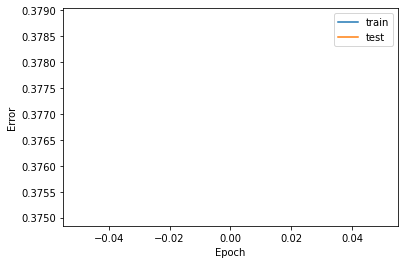

In [14]:
# https://github.com/khanhnamle1994/MetaRec/blob/b5e36cb579a88b32cdfb728f35f645d76b24ad95/Boltzmann-Machines-Experiments/RBM-CF-PyTorch/rbm.py#L23
# Create the Restricted Boltzmann Machine architecture
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid, k):
        """
        Initialize the parameters (weights and biases) we optimize during the training process
        :param n_vis: number of visible units
        :param n_hid: number of hidden units
        """
        self.i = 0
        self.K = k

        # Weights used for the probability of the visible units given the hidden units
        super().__init__()
        self.W = torch.zeros(k, n_hid, n_vis)  # torch.rand: random normal distribution mean = 0, variance = 1

        # Bias probability of the visible units is activated, given the value of the hidden units (p_v_given_h)
        self.v_bias = torch.zeros(k, 1, n_vis)  # fake dimension for the batch = 1

        # Bias probability of the hidden units is activated, given the value of the visible units (p_h_given_v)
        self.h_bias = torch.zeros(1, n_hid)  # fake dimension for the batch = 1

        if torch.cuda.is_available():
            self.W = self.W.cuda()
            self.v_bias = self.v_bias.cuda()
            self.h_bias = self.h_bias.cuda()
    
    def lr(self):
        return 0.02

    def sample_h(self, x):
        """
        Sample the hidden units
        :param x: the dataset
        """

        # Probability h is activated given that the value v is sigmoid(Wx + a)
        # torch.mm make the product of 2 tensors
        # W.t() take the transpose because W is used for the p_v_given_h

        temp = torch.transpose(self.W, 1, 2)
        wx = torch.bmm(x.cpu(), temp.cpu())
        if torch.cuda.is_available():
            wx = wx.cuda()
        wx_sum = torch.sum(wx, 0)
        # print(wx.shape)

        # Expand the mini-batch
        activation = wx_sum + self.h_bias.expand_as(wx_sum)
        # print(activation.shape)

        # Calculate the probability p_h_given_v
        p_h_given_v = torch.sigmoid(activation)

        # print("h sparse", p_h_given_v.is_sparse, torch.bernoulli(p_h_given_v).is_sparse)

        # Construct a Bernoulli RBM to predict whether an user loves the movie or not (0 or 1)
        # This corresponds to whether the n_hid is activated or not activated
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        """
        Sample the visible units
        :param y: the dataset
        """

        exponents = []
        for k in range(self.K):
            wy = torch.mm(y, self.W[k])
            activation = wy + self.v_bias[k].expand_as(wy)
            exponents.append(torch.exp(activation))

        exponent_tensor = torch.stack(exponents)
        exponent_sum = torch.sum(exponent_tensor, 0)
        probs = []
        for k in range(self.K):
            p_v_k_given_h = exponent_tensor[k] / exponent_sum
            probs.append(p_v_k_given_h)

        p_v_given_h = torch.stack(probs)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train_model(self, v0, vk, ph0, phk):
        """
        Perform contrastive divergence algorithm to optimize the weights that minimize the energy
        This maximizes the log-likelihood of the model
        """

        ph0_K = torch.stack([ph0 for _ in range(self.K)])
        phk_K = torch.stack([phk for _ in range(self.K)])

        pos = torch.bmm(torch.transpose(v0, 1, 2).cpu(), ph0_K.cpu())
        neg = torch.bmm(torch.transpose(vk, 1, 2).cpu(), phk_K.cpu())
        if torch.cuda.is_available():
            pos = pos.cuda()
            neg = neg.cuda()

        w_extra = torch.transpose(pos - neg, 1, 2)
        v_extra = torch.sum((v0 - vk), 1)
        h_extra = torch.sum((ph0 - phk), 0)

        # if self.i % 45 == 0:
            # print(torch.max(w_extra), torch.max(v_extra), torch.max(h_extra), flush=True)

        # Approximate the gradients with the CD algorithm
        # TODO learning rate toevoegen
        self.W += self.lr() * w_extra

        # Add (difference, 0) for the tensor of 2 dimensions
        self.v_bias += self.lr() * v_extra.unsqueeze(1)
        self.h_bias += self.lr() * h_extra
        self.i += 1

def score_model(rbm: RBM, batch_size, train_matrix, test_matrix):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0] - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        v = convert_sparse_matrix_to_sparse_tensor(v)
        vt = convert_sparse_matrix_to_sparse_tensor(vt)

        v = v.to_dense()
        vt = vt.to_dense()
        v = v.sub(1)
        vt = vt.sub(1)
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()

        if len(vt[vt > -1]) > 0:
            _, h = rbm.sample_h(v)
            v, _ = rbm.sample_v(h)

            # Update test RMSE reconstruction error
            test_recon_error += torch.sqrt(torch.mean((vt[vt > -1] - v[vt > -1])**2)) * len(vt > -1)
            s += len(vt > -1) 

    return test_recon_error / s


# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X, k=5):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.DoubleTensor(values)
    tensor_list = []

    for index in range(k):
        value = index + 1
        yeet = torch.where(v == value, 2., 1.)
        shape = coo.shape
        tensor = torch.sparse.DoubleTensor(i, yeet, torch.Size(shape)) 
        if torch.cuda.is_available():
            tensor = tensor.cuda()

        tensor_list.append(tensor)

    tensor = torch.stack(tensor_list) 
    return tensor

def create_rbm(train_matrix, test_matrix, n_hidden, batch_size, epochs, rbm=None, k=5) -> RBM:
    n_vis = train_matrix.shape[1]
    train_errors = []
    test_errors = []
    if rbm is None:
        rbm = RBM(n_vis, n_hidden, k)

    print("start training")
    for epoch in tqdm(range(epochs)):
        rbm.train()
        train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
        s = 0
        
        for user_id in range(0, train_matrix.shape[0] - batch_size, batch_size):
            training_sample = train_matrix[user_id : user_id + batch_size]
            training_sample2 = train_matrix[user_id : user_id + batch_size]
            # print(training_sample)
            v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)
            # print(v0.coalesce().indices())
            vk = convert_sparse_matrix_to_sparse_tensor(training_sample2)

            v0 = v0.to_dense()
            vk = vk.to_dense()
            v0 = v0.sub(1)
            vk = vk.sub(1)
            # v0[v0 == -2] = 0
            # vk[vk == -2] = 0


            # v0.unsqueeze_(-1)
            # v0 = v0.expand(v0.shape[0], v0.shape[1], rbm.K)
            # vk.unsqueeze_(-1)
            # vk = vk.expand(vk.shape[0], vk.shape[1], rbm.K)

            # v0 = torch.transpose(v0, 0, 2)
            # vk = torch.transpose(vk, 0, 2)

            # for i in range(rbm.K):
            #     v0[i][v0[i] != i+1] = 0
            #     # v0[i][(v0[i] != i+1) & (v0[i] != -1)] = 0
            #     v0[i][v0[i] == i+1] = 1
            
            ph0, _ = rbm.sample_h(v0)

            # Third for loop - perform contrastive divergence
            # TODO misschien is iets lager proberen?
            for k in range(1):
                _, hk = rbm.sample_h(vk)
                _, vk = rbm.sample_v(hk)

                # We don't want to learn when there is no rating by the user, and there is no update when rating = -1
                # Remove indices from vk vector that are not in the v0 vector => get sparse tensor again
                vk[v0 < 0] = v0[v0 < 0]
                

            phk, _ = rbm.sample_h(vk)

            rbm.train_model(v0, vk, ph0, phk)
            vk, _ = rbm.sample_v(hk)
            
            train_recon_error += torch.sqrt(torch.mean((v0[v0 > -1] - vk[v0 > -1])**2)) * len(v0 > -1)
            s += len(v0 > -1)
            
        train_errors.append(train_recon_error / s)

        # print('calculating test scores')
        rbm.eval()
        test_errors.append(score_model(rbm, batch_size, train_matrix, test_matrix))

        # print('finished epoch', epoch)    

    import matplotlib.pyplot as plt
    # Plot the RMSE reconstruction error with respect to increasing number of epochs
    plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
    plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'netflix-{n_hidden}-{batch_size}-{epochs}.jpg')

    return rbm

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)
create_rbm(train_matrix, test_matrix, 100, 1000, 10, k=5)

NameError: name 'train_errors' is not defined

In [43]:
# import gc
# 
# gc.collect()

# torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.